In [1]:
import numpy as np

import sys
import os
current = os.path.dirname(os.path.realpath(__vsc_ipynb_file__))
parent = os.path.dirname(current)
sys.path.append(parent+'/src')

from sensorsim import *

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['helvetica'],'size': 16})
rc('text', usetex=True)


## Simple examples

### Two spins

We consider learning a single magnetic field

Make plot of Fisher information matrix elements in $(t,\tau)$ space

### Three spins

### Dipolar geometry

In [2]:

def get_dipolar_interactions(R, nA, nB, alpha=3, phi=0):
    N = R.shape[1]
    # print(R.shape)
    Rs = jnp.abs(R[:, np.newaxis, :] - R[:,:,np.newaxis])
    rs = jnp.sqrt(np.sum(Rs**2, axis=0))
    # print(rs.shape)
    # print(rs)
    #jnp.fill_diagonal(rs, jnp.inf)

    # angular anisotropy
    n = jnp.array([np.sin(phi), 0, np.cos(phi)])
    #print(Rs.shape)
    #print(n.shape)
    qs = 3 * (jnp.tensordot(n, Rs, axes=1)/rs) ** 2 - 1
    #jnp.fill_diagonal(qs, 1.0)

    J = qs/(rs**alpha)
    diag_elements = jnp.diag_indices_from(J)
    J = J.at[diag_elements].set(0)

    indsA = jnp.arange(nA)
    indsB = jnp.arange(nA, nA+nB)
    JAB = J[indsA[:,jnp.newaxis],indsB[jnp.newaxis,:]]
    JBB = J[indsB[:,jnp.newaxis],indsB[jnp.newaxis,:]]


    return JAB, JBB

def get_toy_example_B(nB, d, phi=0):
    # theta is angle B field makes with quant axis
    #B = jnp.array([jnp.sin(theta), 0, jnp.cos(theta)])g
    
    def build_molecule_positions(N):

        angles = (2*jnp.pi/N) * jnp.arange(N)
        R = jnp.zeros([3,N])
        R = R.at[0,:].set(jnp.cos(angles))
        R = R.at[1,:].set(jnp.sin(angles))
        return R
    
    RA = jnp.zeros([3,2]) 
    RB = build_molecule_positions(nB)
    RA = d*RA.at[2,:].set(jnp.array([1,-1]))

    R = jnp.hstack([RA,RB])
    #print(R.shape)
    nA = 2
    JAB, JBB = get_dipolar_interactions(R, nA, nB, phi = phi)
    
    return JAB, JBB

In [3]:
# initial states

psi0_A = jnp.array([1,1], dtype='complex128')/jnp.sqrt(2)

# Nanoscale context!!
# two qubit sensors

I = jnp.array([[1,0],[0,1]])
Z = jnp.array([[1,0],[0,-1]])
X = jnp.array([[0,1],[1,0]])
Y = jnp.array([[0,-1j],[1j,0]])

psi0_product = jnp.kron(psi0_A, psi0_A)
psi0_bell_1 = jnp.array([1,0,0,1])/jnp.sqrt(2)
psi0_bell_x = jnp.kron(X, I) @ psi0_bell_1
psi0_bell_y = jnp.kron(Y, I) @ psi0_bell_1
psi0_bell_z = jnp.kron(Z, I) @ psi0_bell_1

psi0_list = [psi0_product, psi0_bell_1, psi0_bell_x, psi0_bell_y, psi0_bell_z]





In [4]:
get_toy_example_B(4,5)

(DeviceArray([[0.01421552, 0.01421552, 0.01421552, 0.01421552],
              [0.01421552, 0.01421552, 0.01421552, 0.01421552]],            dtype=float64),
 DeviceArray([[ 0.        , -0.35355339, -0.125     , -0.35355339],
              [-0.35355339,  0.        , -0.35355339, -0.125     ],
              [-0.125     , -0.35355339,  0.        , -0.35355339],
              [-0.35355339, -0.125     , -0.35355339,  0.        ]],            dtype=float64))

In [4]:
hyperparams = {}
args = {}

# system size
nA = 2
nB = 6
hyperparams['nA'] = nA 
hyperparams['nB'] = nB 

# time evolution params
beta = 0
dbeta = 1e-2
tau = 2
dtau = 1e-2
t = 2
n_measure = 2
dt = 1e-2
ts = jnp.arange(0,t,n_measure*dt)

hyperparams['t'] = t 
hyperparams['n_measure'] = n_measure 
hyperparams['dt'] = dt 
hyperparams['tau'] = tau 
hyperparams['dtau'] = dtau
hyperparams['beta'] = beta 
hyperparams['dbeta'] = dbeta

ts = np.arange(0, t, n_measure*dt)
N_t = len(ts)
N_tau = int(tau/dtau)

hyperparams['reverse_sense'] = True

gAB = jnp.array([1,1,-2])
gB = jnp.array([1,1,-2])
hyperparams['gAB']= gAB
hyperparams['gB'] = gB

# initial state params
M = 100
hyperparams['psi0_A'] = psi0_product
hyperparams['M'] = M

sim = SensorSim(nA, nB)
F, gradF = sim.simulate_sensor_state(hyperparams) # rhoA, drhoA

In [5]:
args = {}

# Ham params
m = 0
np.random.seed(m)
Delta = np.random.standard_normal(nB)
d = 1
JAB, JB = get_toy_example_B(nB, d)
theta = encode_params(JAB, JB, Delta)

# seconding
rho = F(theta, args)
drho = gradF(theta, args)

In [6]:
def vec2op(rho_vec):
    dimH = int(np.sqrt(rho_vec.shape[0]))
    return np.reshape(rho_vec, [dimH, dimH])

def op2vec(rho_op):
    return jnp.ravel(rho_op)

def get_QFIM(rhos, drhos):
    # returns both the list of SLDs and QFIM
    # assume rhos is (N_t, 2**nA, 2**nA)
    # assume drhos is (N_t, 2**nA, 2**nA, dimTheta)

    # will return the qfim, list of (dimTheta, dimTheta)
    # will return slds, list of (dimTheta, 2**nA, 2**nA)
    dimH = rhos.shape[1]
    dimTheta = drhos.shape[3]

    F_list = []
    l_list = []
    
    for k in range(N_t):
        rho = rhos[k,:,:]
        drho = drhos[k,:,:,:]
        #dimH = rho.shape[0]

    # work in vectorized formalism
        rho1 = np.kron(rho, np.eye(dimH))
        rho2 = np.kron(np.eye(dimH), rho.conj())
        S = np.linalg.pinv(rho1+rho2)
    
        F = np.zeros([dimTheta, dimTheta])
        ls = np.zeros([dimTheta, dimH, dimH], dtype='complex128')
    
        for a in range(dimTheta):
            drho_a = drho[:,:,a]
            drho_a_vec = op2vec(drho_a)
            la = S @ drho_a_vec
            ls[a,:,:] = vec2op(la)
            
            for b in range(dimTheta):
                drho_b = drho[:,:,b]
                drho_b_vec = op2vec(drho_b)
                F[a,b] = np.dot(drho_b_vec.conj(), la)

        F_list.append(F)
        l_list.append(ls)

    return F_list, l_list

F_list, l_list = get_QFIM(rho, drho)

/var/folders/nb/5gbs4wt96rs93v4n58zhrnjh0000gn/T/ipykernel_10491/652034146.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  F[a,b] = np.dot(drho_b_vec.conj(), la)


Text(0, 0.5, 'QFI $\\mathcal{F}_{\\mu \\mu}$')

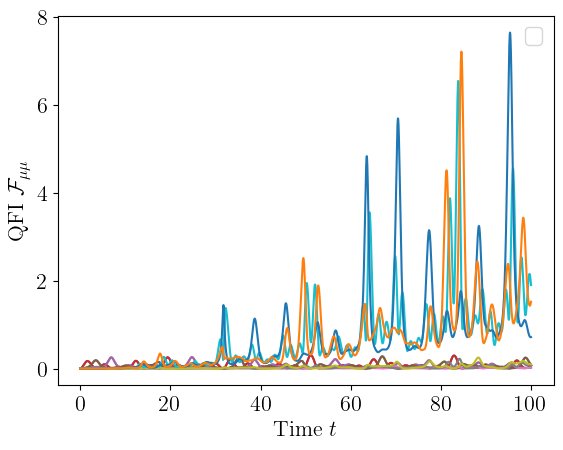

In [9]:
for a in range(len(theta)):
    plt.plot(ts, np.array([F[a,a] for F in F_list]))
plt.legend()
plt.xlabel(r'Time $t$')
plt.ylabel(r'QFI $\mathcal{F}_{\mu \mu}$')

0.00575742930146491
0.001290257312038386
0.0032545653677603856
0.00981390488359373
0.005754245605379223
0.006584882464246204
0.005757429301464916
0.001290257312038379
0.0032545653677603804
0.009813904883593714
0.005754245605379208
0.0065848824642462216
1.170967215277472e-05
4.626765292187356e-06
2.3721814312967224e-06
2.971293082177903e-06
2.9997861618221604e-06
1.8012714536532735e-05
1.3696731822871532e-06
1.642475782851578e-06
3.6580010305781564e-06
1.3924397934432829e-05
2.958286514236645e-06
9.751116717267618e-07
2.7715665686547133e-05
1.0663979994077067e-06
2.91637006541432e-06
6.068653337758264e-05
2.9230407929819416e-05
4.0167772663589675e-05
5.645278002069004e-05
4.1982286385529703e-05
0.00012474803909867286


Text(0, 0.5, 'QFI $\\mathcal{F}_{\\mu \\mu}$')

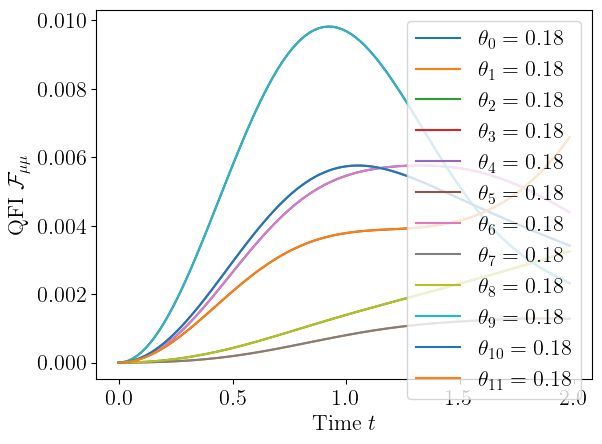

In [19]:
for a in range(len(theta)):
    print(np.max(np.array([F[a,a] for F in F_list])))
    if np.max(np.array([F[a,a] for F in F_list]))>0.001:
        plt.plot(ts, np.array([F[a,a] for F in F_list]), label=labels[a])
plt.legend()
plt.xlabel(r'Time $t$')
plt.ylabel(r'QFI $\mathcal{F}_{\mu \mu}$')

In [8]:
labels = [r'$\theta_{%d} = %1.2f$'%(a, th) for a, th in enumerate(theta)]

In [9]:
labels

['$\\theta_{0} = 0.18$',
 '$\\theta_{1} = 0.18$',
 '$\\theta_{2} = 0.18$',
 '$\\theta_{3} = 0.18$',
 '$\\theta_{4} = 0.18$',
 '$\\theta_{5} = 0.18$',
 '$\\theta_{6} = 0.18$',
 '$\\theta_{7} = 0.18$',
 '$\\theta_{8} = 0.18$',
 '$\\theta_{9} = 0.18$',
 '$\\theta_{10} = 0.18$',
 '$\\theta_{11} = 0.18$',
 '$\\theta_{12} = -1.00$',
 '$\\theta_{13} = -0.19$',
 '$\\theta_{14} = -0.12$',
 '$\\theta_{15} = -0.19$',
 '$\\theta_{16} = -1.00$',
 '$\\theta_{17} = -1.00$',
 '$\\theta_{18} = -0.19$',
 '$\\theta_{19} = -0.13$',
 '$\\theta_{20} = -0.19$',
 '$\\theta_{21} = -1.00$',
 '$\\theta_{22} = -0.19$',
 '$\\theta_{23} = -0.12$',
 '$\\theta_{24} = -1.00$',
 '$\\theta_{25} = -0.19$',
 '$\\theta_{26} = -1.00$',
 '$\\theta_{27} = 1.76$',
 '$\\theta_{28} = 0.40$',
 '$\\theta_{29} = 0.98$',
 '$\\theta_{30} = 2.24$',
 '$\\theta_{31} = 1.87$',
 '$\\theta_{32} = -0.98$']